In [1]:
# cell 1: environment & imports
import os
# hide TF INFO logs (keep oneDNN enabled)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import math
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# file paths
PROJECT = Path.cwd()
DATA_DIR = PROJECT / 'data'
OUT_DIR = PROJECT / 'output'
MODEL_DIR = PROJECT / 'models'
OUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print("Project root:", PROJECT)
print("Data folder exists:", DATA_DIR.exists())


Project root: c:\Users\shubh\Desktop\solar
Data folder exists: True


In [2]:
# cell 2: inspect raw CSV headers
gen_fp = DATA_DIR / 'Plant_1_Generation_Data.csv'
wea_fp = DATA_DIR / 'Plant_1_Weather_Sensor_Data.csv'

print("Generation file exists:", gen_fp.exists())
print("Weather file exists:", wea_fp.exists())
if gen_fp.exists():
    display(pd.read_csv(gen_fp, nrows=5))
if wea_fp.exists():
    display(pd.read_csv(wea_fp, nrows=5))


Generation file exists: True
Weather file exists: True


,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0,0,0,6259559
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0,0,0,6183645
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0,0,0,6987759
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0,0,0,7602960
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0,0,0,7158964


,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0


In [5]:
# Check how timestamps look in both files
print("GENERATION file:")
print(gen_fp)
g = pd.read_csv(gen_fp, nrows=5)
display(g.head())
print("\nColumn names:", g.columns.tolist())

print("\nWEATHER file:")
w = pd.read_csv(wea_fp, nrows=5)
display(w.head())
print("\nColumn names:", w.columns.tolist())


GENERATION file:
c:\Users\shubh\Desktop\solar\data\Plant_1_Generation_Data.csv


,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0,0,0,6259559
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0,0,0,6183645
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0,0,0,6987759
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0,0,0,7602960
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0,0,0,7158964



Column names: ['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']

WEATHER file:


,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0



Column names: ['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']


In [6]:
import pandas as pd
import numpy as np
from pathlib import Path  # CORRECTED: Added necessary imports

def clean_and_merge(gen_fp, wea_fp, out_fp, tolerance_minutes=15):
    """Read generation + weather CSVs, parse datetimes, and merge using nearest timestamp per PLANT_ID.

    - gen_fp, wea_fp: file paths (CSV)
    - out_fp: output csv path
    - tolerance_minutes: maximum time difference allowed for a match
    """
    gen = pd.read_csv(gen_fp)
    wea = pd.read_csv(wea_fp)

    # Normalize column names
    gen.columns = [c.strip() for c in gen.columns]
    wea.columns = [c.strip() for c in wea.columns]

    # === 1) Parse datetimes ===
    def find_dt_col(df):
        for c in ['DATE_TIME', 'date_time', 'Date_Time', 'DateTime', 'timestamp', 'TIME_STAMP', 'DATE']:
            if c in df.columns:
                return c
        # fallback: first column that parses to datetime
        for c in df.columns:
            try:
                # Test parsing on a small sample
                pd.to_datetime(df[c].dropna().iloc[:5])
                return c
            except Exception:
                pass
        return None

    gen_dt_col = find_dt_col(gen)
    wea_dt_col = find_dt_col(wea)
    if gen_dt_col is None or wea_dt_col is None:
        raise KeyError("Could not find a parsable datetime column in one of the CSVs")

    # CORRECTED: Rename found columns to a standard 'DATE_TIME' *before* parsing.
    # This avoids creating duplicate datetime columns (e.g., 'timestamp' and 'DATE_TIME').
    gen = gen.rename(columns={gen_dt_col: 'DATE_TIME'})
    wea = wea.rename(columns={wea_dt_col: 'DATE_TIME'})

    # Parse generation DATETIME with dayfirst=True (sample showed dd-mm-yyyy)
    try:
        gen['DATE_TIME'] = pd.to_datetime(gen['DATE_TIME'], dayfirst=True, errors='coerce')
    except Exception:
        gen['DATE_TIME'] = pd.to_datetime(gen['DATE_TIME'], errors='coerce')

    # Parse weather DATETIME normally (fallback dayfirst if parsing fails)
    try:
        wea['DATE_TIME'] = pd.to_datetime(wea['DATE_TIME'], errors='coerce')
    except Exception:
        wea['DATE_TIME'] = pd.to_datetime(wea['DATE_TIME'], dayfirst=True, errors='coerce')

    # Report parsing problems
    bad_gen = gen['DATE_TIME'].isna().shape[0]
    # CORRECTED: Removed the 'if False' which was a bug preventing checks.
    bad_wea = wea['DATE_TIME'].isna().shape[0]
    
    if bad_gen > 0:
        print(f"Warning: {bad_gen} rows in generation file could not be parsed as datetime (set to NaT).")
    if bad_wea > 0:
        print(f"Warning: {bad_wea} rows in weather file could not be parsed as datetime (set to NaT).")

    # round datetimes to tolerance window so both sources align
    gen['DATE_TIME'] = gen['DATE_TIME'].dt.round(f'{tolerance_minutes}min')
    wea['DATE_TIME'] = wea['DATE_TIME'].dt.round(f'{tolerance_minutes}min')

    # === 2) Choose join key: PLANT_ID if present, else fallback to synthetic SPLIT ===
    join_key = None
    for k in ['PLANT_ID', 'Plant_ID', 'plant_id', 'PLANT', 'SOURCE_KEY']:
        if k in gen.columns and k in wea.columns:
            join_key = k
            break

    if join_key is None:
        # fallback: create synthetic key so merge will be across all rows
        gen['PLANT_ID'] = 1
        wea['PLANT_ID'] = 1
        join_key = 'PLANT_ID'
        print("No common PLANT_ID/SOURCE_KEY found — using synthetic PLANT_ID=1 for both files.")
    
    # unify join column name
    gen = gen.rename(columns={join_key: 'PLANT_ID'})
    wea = wea.rename(columns={join_key: 'PLANT_ID'})

    # dedupe & sort
    gen = gen.drop_duplicates(subset=['PLANT_ID', 'DATE_TIME']).sort_values('DATE_TIME').reset_index(drop=True)
    wea = wea.drop_duplicates(subset=['PLANT_ID', 'DATE_TIME']).sort_values('DATE_TIME').reset_index(drop=True)

    # === 3) Diagnostics: how many timestamps overlap exactly? ===
    gen_times = set(gen['DATE_TIME'].dropna().unique())
    wea_times = set(wea['DATE_TIME'].dropna().unique())
    common_exact = len(gen_times.intersection(wea_times))
    print(f"Generation rows: {len(gen)}, Weather rows: {len(wea)}, Exact timestamp matches: {common_exact}")

    # === 4) Merge using merge_asof (nearest timestamp within tolerance) ===
    tol = pd.Timedelta(f'{tolerance_minutes}min')
    
    # Ensure data is sorted for merge_asof
    gen = gen.sort_values('DATE_TIME')
    wea = wea.sort_values('DATE_TIME')
    
    merged = pd.merge_asof(
        gen,
        wea,
        on='DATE_TIME',
        by='PLANT_ID',
        direction='nearest',
        tolerance=tol
    )

    # If merge produced rows without weather, drop them using a required weather column
    weather_required_col = None
    for c in ['IRRADIATION', 'irradiation', 'AMBIENT_TEMPERATURE', 'ambient_temp', 'MODULE_TEMPERATURE']:
        if c in merged.columns:
            weather_required_col = c
            break

    if weather_required_col:
        before = len(merged)
        merged = merged[~merged[weather_required_col].isna()].reset_index(drop=True)
        after = len(merged)
        if before > after:
            print(f"Dropped {before - after} merged rows with missing weather ({weather_required_col}).")

    # Final clean: replace infs, forward/backfill
    merged = merged.replace([np.inf, -np.inf], np.nan)
    
    # CORRECTED: Apply fillna *within each group* to prevent data leakage across PLANT_IDs.
    # Sort by time first to ensure ffill/bfill work chronologically.
    merged = merged.sort_values(['PLANT_ID', 'DATE_TIME'])
    # Apply ffill and bfill *inside* a groupby.apply to keep them contained.
    merged = merged.groupby('PLANT_ID', group_keys=False).apply(lambda g: g.ffill().bfill())
    merged = merged.reset_index(drop=True) # drop the group index

    if merged.empty:
        raise ValueError("Merged dataset is empty after merge_asof — try increasing tolerance or inspect timestamps/keys.")

    # final save
    # CORRECTED: Convert out_fp (str) to a Path object to allow .parent.mkdir()
    out_fp = Path(out_fp)
    out_fp.parent.mkdir(parents=True, exist_ok=True)
    
    merged.to_csv(out_fp, index=False)
    print(f"Saved merged file with {len(merged)} rows to {out_fp}")
    return merged

In [7]:
cleaned_fp = OUT_DIR / 'Cleaned_Plant1_Data.csv'
merged = clean_and_merge(gen_fp, wea_fp, cleaned_fp, tolerance_minutes=15)
print("Merged shape:", merged.shape)
merged.head()


Generation rows: 3158, Weather rows: 3182, Exact timestamp matches: 3157
Saved merged file with 3158 rows to c:\Users\shubh\Desktop\solar\output\Cleaned_Plant1_Data.csv
Merged shape: (3158, 11)


C:\Users\shubh\AppData\Local\Temp\ipykernel_17500\2912539367.py:135: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged = merged.groupby('PLANT_ID', group_keys=False).apply(lambda g: g.ffill().bfill())


,DATE_TIME,PLANT_ID,SOURCE_KEY_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [8]:
# cell 5: simulate Umbra telemetry
def simulate_umbra(merged_df, out_fp, n_units=25, panel_area=0.3, panel_eff=0.18, seed=42):
    np.random.seed(seed)
    rows = []
    for _, r in merged_df.iterrows():
        t = r['DATE_TIME']
        irr = r.get('IRRADIATION', r.get('irradiation', 0.0))
        ambient = r.get('AMBIENT_TEMPERATURE', r.get('ambient_temp', np.nan))
        module_temp = r.get('MODULE_TEMPERATURE', r.get('module_temp', np.nan))
        hour = pd.to_datetime(t).hour
        for uid in range(1, n_units+1):
            power_generated_w = float(irr) * panel_area * panel_eff * 1000.0
            base_use = np.random.uniform(4, 20)
            power_used_w = base_use + (np.random.uniform(10,40) if 9 <= hour <= 18 else np.random.uniform(0,8))
            battery_level = float(np.clip(np.random.normal(70, 12), 5, 100))
            humidity = np.random.uniform(20, 80)
            wind = np.random.uniform(0.2, 6.0)
            rows.append({
                'timestamp': t,
                'umbrella_id': uid,
                'irradiance': irr,
                'ambient_temp': ambient,
                'module_temp': module_temp,
                'power_generated_W': power_generated_w,
                'power_used_W': power_used_w,
                'battery_level_%': battery_level,
                'humidity_%': humidity,
                'wind_speed_mps': wind,
                'hour': hour,
                'day_of_week': pd.to_datetime(t).dayofweek
            })
    df = pd.DataFrame(rows)
    df = df.sort_values(['umbrella_id','timestamp']).reset_index(drop=True)
    df['next_battery_%'] = df.groupby('umbrella_id')['battery_level_%'].shift(-1)
    df = df.dropna().reset_index(drop=True)
    out_fp.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(out_fp, index=False)
    return df


In [9]:
# cell 6: run simulation
sim_fp = OUT_DIR / 'Umbra_IoT_Simulated.csv'
sim_df = simulate_umbra(merged, sim_fp, n_units=25)
print("Sim rows:", len(sim_df))
sim_df.head()


Sim rows: 78925


,timestamp,umbrella_id,irradiance,ambient_temp,module_temp,power_generated_W,power_used_W,battery_level_%,humidity_%,wind_speed_mps,hour,day_of_week,next_battery_%
0,2020-05-15 00:00:00,1,0.0,25.184316,22.857507,0.0,17.598356,77.772262,29.361118,1.104768,0,4,60.372673
1,2020-05-15 00:15:00,1,0.0,25.084589,22.761668,0.0,17.924802,60.372673,41.817776,5.836336,0,4,76.180572
2,2020-05-15 00:30:00,1,0.0,24.935753,22.592306,0.0,23.430686,76.180572,67.897711,3.969791,0,4,70.252046
3,2020-05-15 00:45:00,1,0.0,24.846130,22.360852,0.0,10.313928,70.252046,74.322919,0.729463,0,4,64.599214
4,2020-05-15 01:00:00,1,0.0,24.621525,22.165423,0.0,23.861924,64.599214,47.032648,0.949125,1,4,76.755631


In [10]:
# cell 7: preprocessing
from sklearn.preprocessing import MinMaxScaler

FEATURE_COLS = ['irradiance','ambient_temp','module_temp','power_generated_W',
                'power_used_W','battery_level_%','hour','day_of_week']
TARGET = 'next_battery_%'
SEQ_LEN = 24
TEST_SPLIT = 0.2

def prepare_sequences(df, feature_cols, target_col, seq_len=24, test_split=0.2):
    df = df.sort_values('timestamp').reset_index(drop=True)
    feats = df[feature_cols].values
    target = df[[target_col]].values
    feat_scaler = MinMaxScaler()
    tgt_scaler = MinMaxScaler()
    feats_scaled = feat_scaler.fit_transform(feats)
    target_scaled = tgt_scaler.fit_transform(target)
    X, y = [], []
    for i in range(seq_len, len(df)):
        X.append(feats_scaled[i-seq_len:i, :])
        y.append(target_scaled[i, 0])
    X = np.array(X); y = np.array(y)
    split = int((1-test_split) * len(X))
    return X[:split], X[split:], y[:split], y[split:], feat_scaler, tgt_scaler


In [11]:
# cell 8: prepare sequences for a single umbrella (id=1) to keep example simple
unit_id = 1
df_unit = sim_df[sim_df['umbrella_id']==unit_id].reset_index(drop=True)
X_train, X_test, y_train, y_test, feat_scaler, tgt_scaler = prepare_sequences(df_unit, FEATURE_COLS, TARGET, seq_len=SEQ_LEN, test_split=TEST_SPLIT)
print("X_train shape:", X_train.shape)

np.save(OUT_DIR / 'X_train.npy', X_train)
np.save(OUT_DIR / 'X_test.npy', X_test)
np.save(OUT_DIR / 'y_train.npy', y_train)
np.save(OUT_DIR / 'y_test.npy', y_test)
with open(MODEL_DIR / 'scaler_features.pkl','wb') as f: pickle.dump(feat_scaler, f)
with open(MODEL_DIR / 'scaler_target.pkl','wb') as f: pickle.dump(tgt_scaler, f)
print("Saved arrays and scalers.")


X_train shape: (2506, 24, 8)
Saved arrays and scalers.


In [12]:
# === cell 9: build & train ===

import tensorflow as tf
from tensorflow import keras

# ✅ This makes Pylance happy and still works identically
callbacks = keras.callbacks

def build_lstm(seq_len, n_features):
    model = keras.Sequential([
        keras.layers.LSTM(128, return_sequences=True, input_shape=(seq_len, n_features)),
        keras.layers.Dropout(0.2),
        keras.layers.LSTM(64),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# === Training ===
seq_len = X_train.shape[1]
n_features = X_train.shape[2]

model = build_lstm(seq_len, n_features)
model.summary()

ckpt = MODEL_DIR / 'umbra_lstm_best.h5'

# ✅ define callbacks through keras.callbacks (no direct submodule import)
callback_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    callbacks.ModelCheckpoint(str(ckpt), save_best_only=True, monitor='val_loss'),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)
]

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=callback_list,
    verbose=2
)

model.save(MODEL_DIR / 'umbra_lstm_final.h5')
print("✅ Model saved to:", MODEL_DIR / 'umbra_lstm_final.h5')


c:\Users\shubh\Desktop\solar\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,665 (475.25 KB)

 Trainable params: 121,665 (475.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


63/63 - 6s - 94ms/step - loss: 0.0386 - mae: 0.1533 - val_loss: 0.0344 - val_mae: 0.1499 - learning_rate: 0.0010
Epoch 2/20


63/63 - 1s - 22ms/step - loss: 0.0309 - mae: 0.1402 - val_loss: 0.0332 - val_mae: 0.1487 - learning_rate: 0.0010
Epoch 3/20


63/63 - 1s - 21ms/step - loss: 0.0300 - mae: 0.1392 - val_loss: 0.0321 - val_mae: 0.1442 - learning_rate: 0.0010
Epoch 4/20


63/63 - 1s - 21ms/step - loss: 0.0298 - mae: 0.1381 - val_loss: 0.0316 - val_mae: 0.1433 - learning_rate: 0.0010
Epoch 5/20
63/63 - 3s - 42ms/step - loss: 0.0293 - mae: 0.1371 - val_loss: 0.0319 - val_mae: 0.1446 - learning_rate: 0.0010
Epoch 6/20
63/63 - 1s - 21ms/step - loss: 0.0294 - mae: 0.1371 - val_loss: 0.0343 - val_mae: 0.1495 - learning_rate: 0.0010
Epoch 7/20
63/63 - 1s - 20ms/step - loss: 0.0305 - mae: 0.1396 - val_loss: 0.0348 - val_mae: 0.1498 - learning_rate: 0.0010
Epoch 8/20
63/63 - 1s - 20ms/step - loss: 0.0296 - mae: 0.1374 - val_loss: 0.0347 - val_mae: 0.1493 - learning_rate: 0.0010
Epoch 9/20
63/63 - 2s - 26ms/step - loss: 0.0291 - mae: 0.1369 - val_loss: 0.0318 - val_mae: 0.1439 - learning_rate: 5.0000e-04
Epoch 10/20
63/63 - 1s - 21ms/step - loss: 0.0291 - mae: 0.1365 - val_loss: 0.0318 - val_mae: 0.1439 - learning_rate: 5.0000e-04
Epoch 11/20
63/63 - 1s - 22ms/step - loss: 0.0288 - mae: 0.1360 - val_loss: 0.0318 - val_mae: 0.1440 - learning_rate: 5.0000e-04
Epoch

✅ Model saved to: c:\Users\shubh\Desktop\solar\models\umbra_lstm_final.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Eval -> MAE: 9.876084223101843 RMSE: 12.24507444382164 R2: 0.0005385859635260726


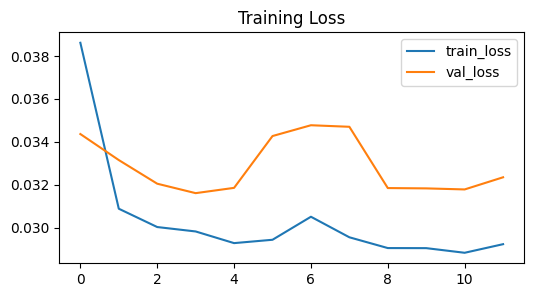

In [13]:
# cell 10: evaluate & save predictions
with open(MODEL_DIR / 'scaler_target.pkl','rb') as f: tgt = pickle.load(f)
y_pred_scaled = model.predict(X_test).flatten()
y_pred = tgt.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_true = tgt.inverse_transform(y_test.reshape(-1,1)).flatten()

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print("Eval -> MAE:", mae, "RMSE:", math.sqrt(mse), "R2:", r2)

pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}).to_csv(OUT_DIR / 'prediction_results.csv', index=False)
# quick loss plot
plt.figure(figsize=(6,3))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Training Loss')
plt.show()
